## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing

# Helper Functions

In [2]:
# plot the histogram of a variable from the dataset to see the skewnes
def plot_skewness_histogram(df):
    k = 0
    plt.figure(figsize=(12, 20))
    for col in df.columns:
      k=k+1
      plt.subplot(6, 5, k)
      sns.histplot(df[col])
      plt.tight_layout()
      plt.title(col + ' (Skewness =' + str(round(df[col].skew(), 3)) +')')

In [3]:
# Helper Function to test the classification model 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
import json


def test_classification_model(model, X, y, test_size=0.2, random_state=42, hyperparameters=None):
    """
    Test a classification model and return evaluation metrics.

    Parameters:
    - model: The classification model to test (e.g., RandomForestClassifier, LogisticRegression, etc.).
    - X: The feature matrix.
    - y: The target vector.
    - test_size: The proportion of the dataset to include in the test split (default is 0.2).
    - random_state: Seed for random number generator for reproducibility (default is 42).
    - hyperparameters: Dictionary of hyperparameters for model tuning (default is None).

    Returns:
    - Dictionary containing the evaluation metrics: accuracy, precision, recall, F1 score, and confusion matrix.
    """
    print("Processing for the Model : {} ".format(model))
    # Split the dataset into training and testing sets
    print("Splitting train and test for the Model : {} ".format(model))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Creating KFold object with 5 splits
    print("Creating KFold object with 5 splits")
    folds = KFold(n_splits=5, random_state=4, shuffle=True)
    print("Configuring hyper parameter  for the Model : {}  with hyperparamer {}".format(model,hyperparameters))
    if hyperparameters is not None:
        # Perform hyperparameter tuning using GridSearchCV
        grid_search = GridSearchCV(model, param_grid = hyperparameters, cv=folds,verbose=2, scoring ='roc_auc',return_train_score=True)
        grid_search.fit(X_train, y_train)
        model_cv = grid_search.best_estimator_
    print("Fitting the Model : {} ".format(model))
    # Fit the model to the training data
    model_cv.fit(X_train, y_train)

    print("Predicting  the Model : {} ".format(model))
    # Make predictions on the test data
    y_pred = model_cv.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    
    
    # Calculate ROC curve and ROC AUC score
    y_prob = model_cv.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


    # Store the metrics in a dictionary
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': confusion,
        'ROC AUC': roc_auc,
        'Best_Model' : model_cv
    }
    # results of GridSearchCV
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print("The CV results for the model {} ".format(model))
    display(cv_results)
    print("The Metrics for the best score {}  and Best Estimator ".format(grid_search.best_score_,grid_search.best_estimator_))
    return metrics

In [51]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

## Exploratory data analysis

In [4]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
#observe the different feature type present in the data

df.shape

(284807, 31)

In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
#Check the Means and Standard deviation to undetstand if we need to scale it 
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
# Check for any null Values 
df.isnull().sum().sum()

0

In [9]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [10]:
# You can see 99% is with Class0 and less than 1% is with class1 . so it is highly imba,lanced 
df['Class'].value_counts(normalize = True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

Here we will observe the distribution of our classes

In [11]:
classes=df['Class'].value_counts()

normal_count = classes[0]
fraud_count = classes[1]
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

In [12]:
plot_data = pd.DataFrame({'Count': [normal_count, fraud_count], 'Percentage': [normal_share, fraud_share]}, index=['Non-Fraudulent', 'Fraudulent'])
plot_data


,Count,Percentage
Non-Fraudulent,284315,99.827251
Fraudulent,492,0.172749


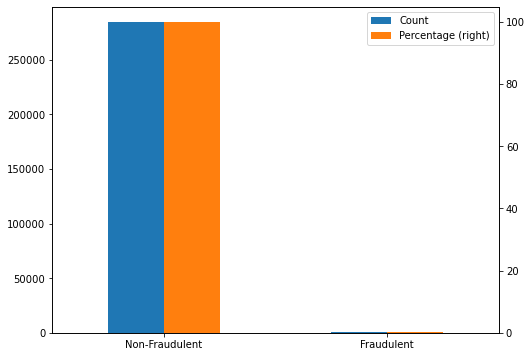

In [13]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
plot_data.plot(kind='bar', secondary_y='Percentage', rot=0, figsize=(8, 6))
plt.show()

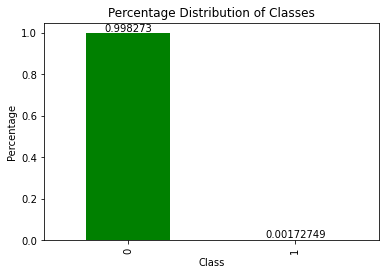

In [14]:
ax = df['Class'].value_counts(normalize = True).plot.bar(color = ['g', 'r'])
ax.bar_label(ax.containers[0], label_type='edge')
plt.title('Percentage Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.show()

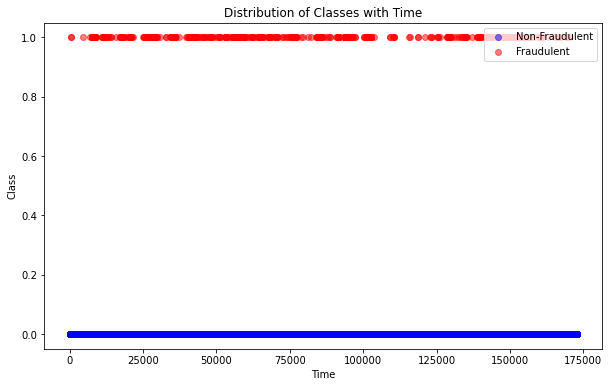

In [15]:
# Create a scatter plot to observe the distribution of classes with time

import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Time'][df['Class'] == 0], df['Class'][df['Class'] == 0], label='Non-Fraudulent', alpha=0.5, c='b')
plt.scatter(df['Time'][df['Class'] == 1], df['Class'][df['Class'] == 1], label='Fraudulent', alpha=0.5, c='r')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Class')
plt.title('Distribution of Classes with Time')
plt.legend(loc='upper right')
plt.show()

# We don;t see any Fradulant with the Time Coloum so probably we can drop this 

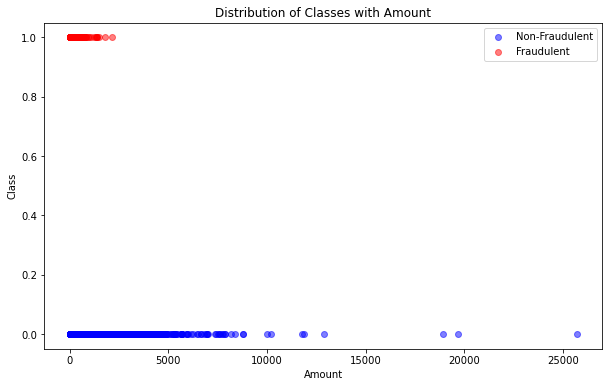

In [16]:
# Create a scatter plot to observe the distribution of classes with Amount
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Amount'][df['Class'] == 0], df['Class'][df['Class'] == 0], label='Non-Fraudulent', alpha=0.5, c='b')
plt.scatter(df['Amount'][df['Class'] == 1], df['Class'][df['Class'] == 1], label='Fraudulent', alpha=0.5, c='r')

# Customize the plot
plt.xlabel('Amount')
plt.ylabel('Class')
plt.title('Distribution of Classes with Amount')
plt.legend(loc='upper right')
plt.show()



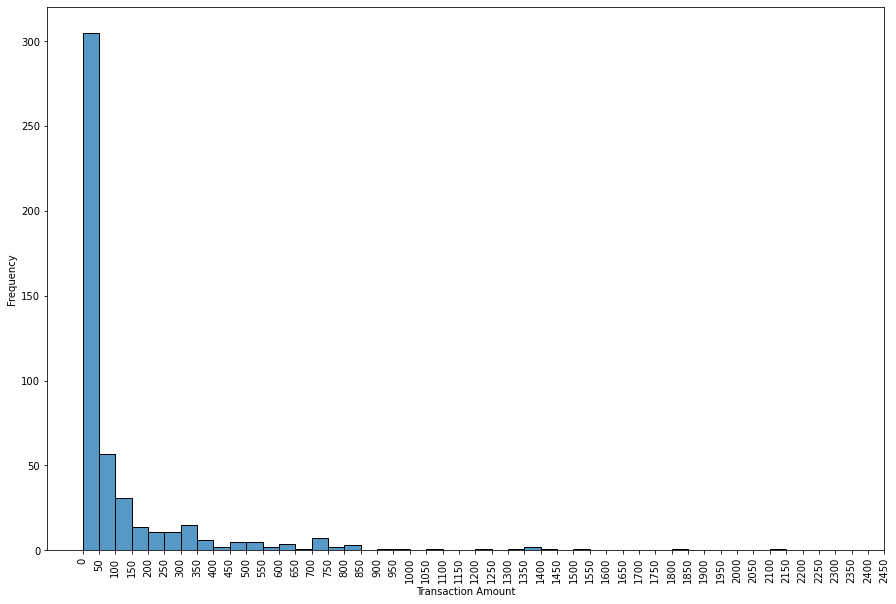

In [17]:
# creating fradulant dataframes
data_fraud = df[df['Class'] == 1]

# Creating non fraudulent dataframe
data_non_fraud = df[df['Class'] == 0]

# distribution of Fradulent data

plt.figure(figsize=(15, 10))
sns.histplot(data_fraud['Amount'], binwidth=50)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.xticks(range(0, 2500, 50), rotation=90)
plt.show()

## Correlation


plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, cbar=False, fmt='.1f', cmap='summer')
plt.show()

In [98]:
## Outlier

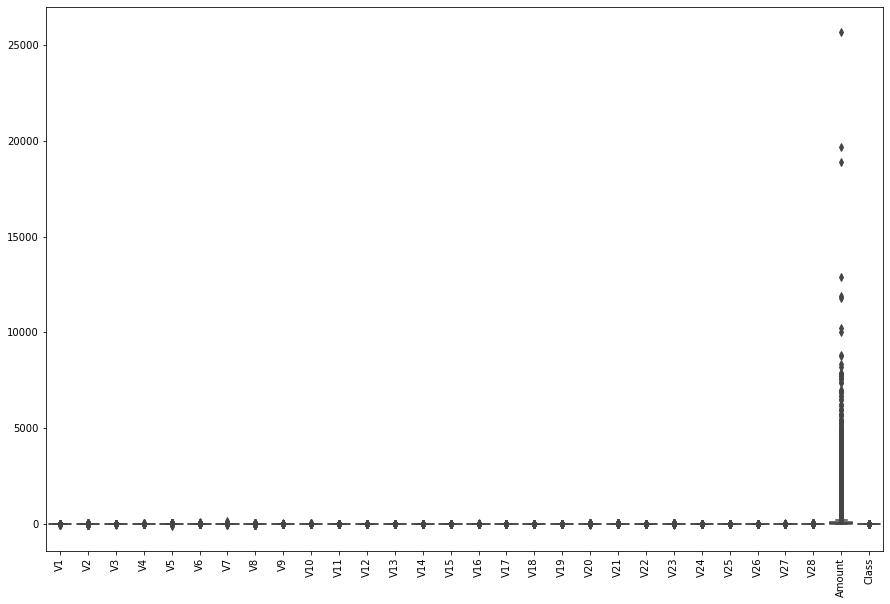

In [99]:
plt.figure(figsize=(15,10))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.show()

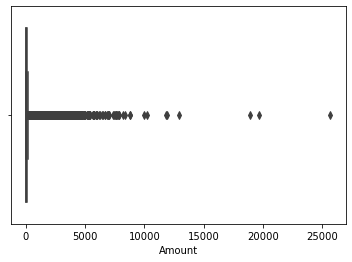

In [100]:
plt.tight_layout()
sns.boxplot(x=data['Amount'], data=data)
plt.show()

#####  Most of the fradulent transactions are in the range of 0-50 dollars

In [18]:
# Drop unnecessary columns. As mentioned above we don;t find much value in "Time" coloumn so dropping it 
data = df.drop('Time', axis=1)

In [19]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [20]:
data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [21]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [22]:
display(data.shape)
display(df.shape)

(284807, 30)

(284807, 31)

### Splitting the data into train & test data

In [23]:
from sklearn.model_selection import train_test_split
# Lables on the y 
y= data['Class']
#  All features in X
X = data.drop(['Class'], axis=1)

In [24]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, stratify=y, random_state=42)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [25]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
344
148


### Plotting the distribution of a variable

In [26]:
#plot_skewness_histogram(X_train)

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [27]:
# Yes you can see the Skewness in the data . 
#- Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
# Based on this https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
#Default is yeo-johnson and the other option is yeo-johnson 

#Parameters:
#method{‘yeo-johnson’, ‘box-cox’}, default=’yeo-johnson’
#The power transform method. Available methods are:

#‘yeo-johnson’ [1], works with positive and negative values

#‘box-cox’ [2], only works with strictly positive values

#standardizebool, default=True
#Set to True to apply zero-mean, unit-variance normalization to the transformed output.

#copybool, default=True
#Set to False to perform inplace computation during transformation.

In [28]:
# Capture all Columns
cols = X_train.columns


# Importing PowerTransformer
from sklearn.preprocessing import PowerTransformer 

# Instantiate the powertransformer
pt = PowerTransformer(standardize=True, copy=False)

# Fit and transform the PT on training data
X_train[cols] = pt.fit_transform(X_train)

In [29]:
# Transform the test set as well 
X_test = pt.transform(X_test)

In [30]:
# plot the histogram of a variable from the dataset again to see the result 
#plot_skewness_histogram(X_train)

## Model Building
### - Build different models on the imbalanced dataset and see the result

In [31]:
#!pip install xgboost

Processing for the Model : RandomForestClassifier() 
Splitting train and test for the Model : RandomForestClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : RandomForestClassifier()  with hyperparamer {'n_estimators': [10, 50, 100], 'max_depth': [10, 20, 30]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................max_depth=10, n_estimators=10; total time=   4.9s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.0s
[CV] END ......................max_depth=10, n_estimators=10; total time=   4.9s
[CV] END ......................max_depth=10, n_estimators=10; total time=   4.8s
[CV] END ......................max_depth=10, n_estimators=10; total time=   4.9s
[CV] END ......................max_depth=10, n_estimators=50; total time=  24.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=  26.0s
[CV] END ......................max_depth=10, n_estimators=50; total t

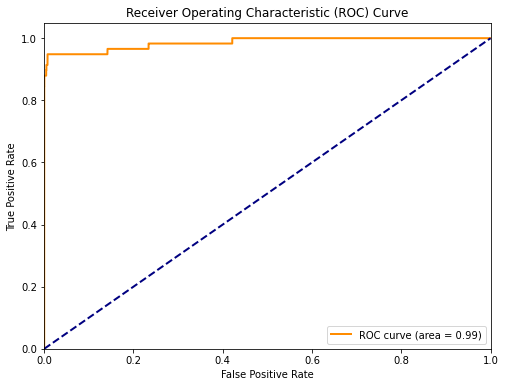

The CV results for the model RandomForestClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.878391,0.039886,0.024662,0.001336,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.970779,0.963446,0.965268,...,0.970562,0.012284,3,0.996339,0.995063,0.991155,0.993704,0.992760,0.993804,1.796090e-03
1,24.618461,0.658418,0.079606,0.003002,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.974195,0.979772,0.968037,...,0.977274,0.010685,1,0.999883,0.996248,0.998484,0.995861,0.998092,0.997714,1.484877e-03
2,48.490174,0.267004,0.151708,0.010371,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.964374,0.973071,0.971133,...,0.971771,0.013676,2,0.999594,0.998580,0.999213,0.997581,0.999909,0.998975,8.260171e-04
3,6.878638,0.233139,0.029449,0.003503,20,10,"{'max_depth': 20, 'n_estimators': 10}",0.901413,0.918070,0.963364,...,0.928922,0.025948,9,0.999998,0.999999,0.999999,0.999999,0.999999,0.999999,5.928718e-07
4,34.210285,1.301184,0.104782,0.007294,20,50,"{'max_depth': 20, 'n_estimators': 50}",0.930434,0.972649,0.957309,...,0.959445,0.016886,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.097155e-07
5,70.801731,2.906242,0.204378,0.013261,20,100,"{'max_depth': 20, 'n_estimators': 100}",0.933000,0.958882,0.970487,...,0.964901,0.020711,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.965068e-17
6,7.157333,0.469671,0.028831,0.001487,30,10,"{'max_depth': 30, 'n_estimators': 10}",0.893713,0.932921,0.948871,...,0.928932,0.020168,8,0.999999,0.999999,0.999999,0.999999,1.000000,0.999999,3.778050e-07
7,35.189574,1.170124,0.102577,0.003490,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.902542,0.923814,0.956745,...,0.931928,0.021013,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.767009e-08
8,71.031981,3.002005,0.200089,0.008908,30,100,"{'max_depth': 30, 'n_estimators': 100}",0.911347,0.940026,0.956463,...,0.945463,0.023082,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.965068e-17


The Metrics for the best score 0.9772742971309075  and Best Estimator 


,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC
0,Random Forest,0.999599,0.9375,0.775862,0.849057,"(DecisionTreeClassifier(max_depth=10, max_feat...","[[39812, 3], [13, 45]]",0.985823


Processing for the Model : LogisticRegression() 
Splitting train and test for the Model : LogisticRegression() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : LogisticRegression()  with hyperparamer {'C': [0.1, 1]}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..............................................C=0.1; total time=   0.7s
[CV] END ..............................................C=0.1; total time=   0.6s
[CV] END ..............................................C=0.1; total time=   0.6s
[CV] END ..............................................C=0.1; total time=   0.7s
[CV] END ..............................................C=0.1; total time=   0.6s
[CV] END ................................................C=1; total time=   0.8s
[CV] END ................................................C=1; total time=   0.7s
[CV] END ................................................C=1; total time=   0.7s
[CV] END ..................................

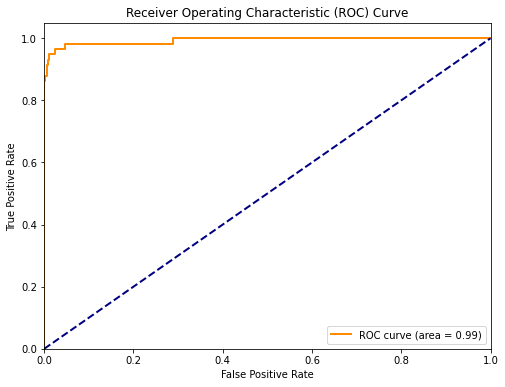

The CV results for the model LogisticRegression() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.623218,0.062007,0.012957,0.003754,0.1,{'C': 0.1},0.985767,0.978822,0.972201,0.993589,...,0.981163,0.007671,1,0.985268,0.985256,0.986053,0.983158,0.988635,0.985674,0.001765
1,0.739477,0.138523,0.009968,0.001356,1,{'C': 1},0.983033,0.977001,0.971953,0.994025,...,0.980299,0.007741,2,0.985043,0.984143,0.985419,0.982550,0.988130,0.985057,0.001827


The Metrics for the best score 0.9811629063639288  and Best Estimator 


,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC
0,Random Forest,0.999599,0.937500,0.775862,0.849057,"(DecisionTreeClassifier(max_depth=10, max_feat...","[[39812, 3], [13, 45]]",0.985823
1,Logistic Regression,0.999273,0.822222,0.637931,0.718447,LogisticRegression(C=0.1),"[[39807, 8], [21, 37]]",0.993083


Processing for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 
Splitting train and test for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early

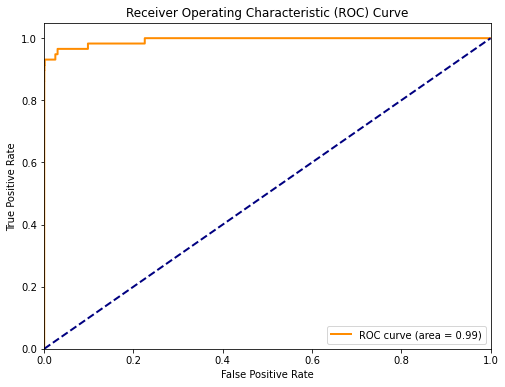

The CV results for the model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.708864,0.132250,0.025188,0.006942,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.962190,0.974564,0.978849,...,0.977082,0.010484,3,0.999894,0.999907,0.999827,0.999474,0.999617,0.999744,0.000170
1,1.762646,0.072874,0.029739,0.012087,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.974586,0.967476,0.978109,...,0.976202,0.011126,4,0.999991,0.999984,0.999919,0.999937,0.999981,0.999963,0.000029
2,1.614335,0.108714,0.026369,0.005653,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.975552,0.975582,0.986912,...,0.980550,0.009061,1,0.999990,0.999965,0.999952,0.999922,0.999984,0.999963,0.000024
3,1.769415,0.178618,0.033428,0.007303,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.944875,0.974370,0.965302,...,0.966210,0.014991,6,0.999998,0.999995,0.999985,0.999986,0.999999,0.999993,0.000006
4,1.864724,0.094176,0.028087,0.009677,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.973699,0.977909,0.967905,...,0.973691,0.013751,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,1.785573,0.195222,0.035433,0.010694,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.967177,0.982916,0.977524,...,0.977265,0.012424,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


The Metrics for the best score 0.9805500090234173  and Best Estimator 


,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC
0,Random Forest,0.999599,0.937500,0.775862,0.849057,"(DecisionTreeClassifier(max_depth=10, max_feat...","[[39812, 3], [13, 45]]",0.985823
1,Logistic Regression,0.999273,0.822222,0.637931,0.718447,LogisticRegression(C=0.1),"[[39807, 8], [21, 37]]",0.993083
2,XGBoost,0.999649,0.923077,0.827586,0.872727,"XGBClassifier(base_score=None, booster=None, c...","[[39811, 4], [10, 48]]",0.993420


Processing for the Model : DecisionTreeClassifier() 
Splitting train and test for the Model : DecisionTreeClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : DecisionTreeClassifier()  with hyperparamer {'max_depth': range(5, 15, 5), 'min_samples_leaf': range(50, 150, 50), 'min_samples_split': range(50, 150, 50)}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=50; total time=   2.2s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=50; total time=   2.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=50; total time=   2.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=50; total time=   2.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=50; total time=   2.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=100; total time=   2.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=100; total time= 

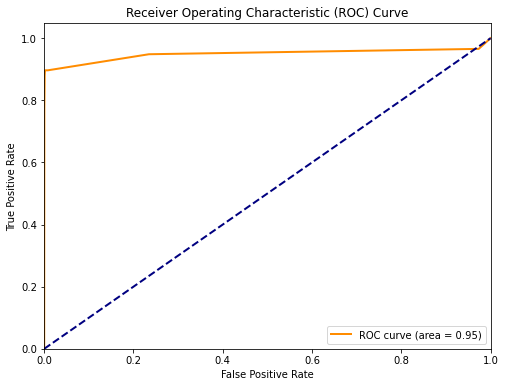

The CV results for the model DecisionTreeClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.107633,0.020599,0.008540,0.000763,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.891165,0.916369,...,0.922593,0.027986,7,0.957599,0.931110,0.958481,0.947409,0.931793,0.945278,0.011944
1,2.102796,0.010734,0.008320,0.000154,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.891121,0.916369,...,0.922585,0.027995,8,0.957599,0.931110,0.958481,0.947409,0.931793,0.945278,0.011944
2,2.099376,0.011280,0.008880,0.000673,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.909744,0.916112,...,0.932352,0.019731,3,0.957217,0.935319,0.961324,0.947203,0.965531,0.953319,0.010861
3,2.113271,0.015203,0.008434,0.000202,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.909744,0.916112,...,0.928964,0.018495,5,0.957217,0.935319,0.961324,0.947203,0.965531,0.953319,0.010861
4,4.185207,0.020022,0.009113,0.000224,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.921732,0.948706,...,0.923568,0.031094,6,0.988162,0.978139,0.985983,0.972753,0.967570,0.978522,0.007771
5,4.181809,0.038430,0.010425,0.001732,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.921668,0.948691,...,0.930409,0.027146,4,0.988158,0.978139,0.985983,0.972753,0.967570,0.978521,0.007770
6,4.129556,0.020813,0.009266,0.000336,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.921455,0.934544,...,0.941543,0.012109,2,0.989941,0.982140,0.989723,0.972257,0.992426,0.985297,0.007375
7,4.286817,0.102986,0.009343,0.000156,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.921652,0.934529,...,0.945044,0.016985,1,0.985409,0.982140,0.989723,0.972257,0.992426,0.984391,0.007019


The Metrics for the best score 0.9450444107276308  and Best Estimator 


,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC
0,Random Forest,0.999599,0.937500,0.775862,0.849057,"(DecisionTreeClassifier(max_depth=10, max_feat...","[[39812, 3], [13, 45]]",0.985823
1,Logistic Regression,0.999273,0.822222,0.637931,0.718447,LogisticRegression(C=0.1),"[[39807, 8], [21, 37]]",0.993083
2,XGBoost,0.999649,0.923077,0.827586,0.872727,"XGBClassifier(base_score=None, booster=None, c...","[[39811, 4], [10, 48]]",0.993420
3,DecisionTree,0.999323,0.762712,0.775862,0.769231,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39801, 14], [13, 45]]",0.949050


Processing for the Model : KNeighborsClassifier() 
Splitting train and test for the Model : KNeighborsClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : KNeighborsClassifier()  with hyperparamer {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time=   4.1s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   3.5s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   3.3s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   3.4s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   3.4s
[CV] END ....................n_neighbors=3, weights=distance; total time=   3.5s
[CV] END ....................n_neighbors=3, weights=distance; total time=   3.5s
[CV] END ....................n_neighbors=3, weights=distance; total tim

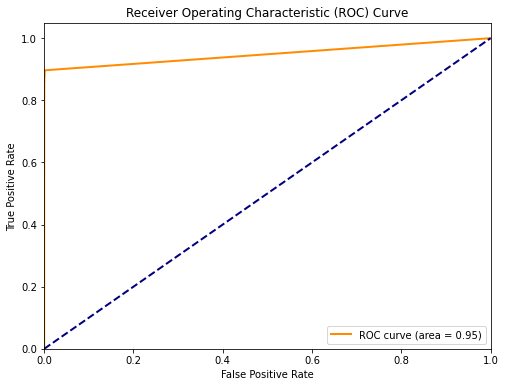

The CV results for the model KNeighborsClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.029092,0.007499,3.514396,0.265028,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.884470,0.899818,0.906687,...,0.908731,0.029191,6,0.999951,0.999948,0.999943,0.999935,0.999951,0.999946,6.251817e-06
1,0.023812,0.001132,3.331238,0.110057,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.884472,0.899825,0.906689,...,0.908737,0.029193,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
2,0.023322,0.000508,3.311080,0.077048,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.884416,0.908129,0.923609,...,0.913756,0.029238,2,0.999910,0.999903,0.999883,0.999876,0.999905,0.999895,1.340101e-05
3,0.024696,0.003195,3.259763,0.036540,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.884429,0.908127,0.923614,...,0.913768,0.029239,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
4,0.023010,0.000473,3.267292,0.066389,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.884364,0.908117,0.923559,...,0.913720,0.029239,4,0.999872,0.999866,0.999841,0.999816,0.999863,0.999852,2.050247e-05
5,0.022939,0.000663,3.254184,0.050574,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.884390,0.908127,0.923572,...,0.913741,0.029241,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.965068e-17


The Metrics for the best score 0.9137677477248495  and Best Estimator 


,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC
0,Random Forest,0.999599,0.937500,0.775862,0.849057,"(DecisionTreeClassifier(max_depth=10, max_feat...","[[39812, 3], [13, 45]]",0.985823
1,Logistic Regression,0.999273,0.822222,0.637931,0.718447,LogisticRegression(C=0.1),"[[39807, 8], [21, 37]]",0.993083
2,XGBoost,0.999649,0.923077,0.827586,0.872727,"XGBClassifier(base_score=None, booster=None, c...","[[39811, 4], [10, 48]]",0.993420
3,DecisionTree,0.999323,0.762712,0.775862,0.769231,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39801, 14], [13, 45]]",0.949050
4,KNN,0.999599,0.903846,0.810345,0.854545,KNeighborsClassifier(weights='distance'),"[[39810, 5], [11, 47]]",0.948178


Processing for the Model : SVC() 
Splitting train and test for the Model : SVC() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : SVC()  with hyperparamer {'C': [0.1], 'kernel': ['linear', 'rbf']}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   5.4s
[CV] END ...............................C=0.1, kernel=linear; total time=   6.2s
[CV] END ...............................C=0.1, kernel=linear; total time=   5.7s
[CV] END ...............................C=0.1, kernel=linear; total time=   6.7s
[CV] END ...............................C=0.1, kernel=linear; total time=   6.0s
[CV] END ..................................C=0.1, kernel=rbf; total time= 5.8min
[CV] END ..................................C=0.1, kernel=rbf; total time= 5.4min
[CV] END ..................................C=0.1, kernel=rbf; total time= 5.7min
[CV] END ..................................C=0.1, kernel=rbf; 

AttributeError: predict_proba is not available when  probability=False

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Define the models to test with Hyperparameter 
models = {
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [10, 50, 100],
        'max_depth': [ 10,20,30]
    }),
    'Logistic Regression': (LogisticRegression(), {
        'C': [0.1, 1]
    }),
    'XGBoost' : (XGBClassifier(max_depth=2, n_estimators=200),{
                'learning_rate': [0.2, 0.6],
                'subsample': [0.3, 0.6, 0.9]
    }),
    'DecisionTree' : (DecisionTreeClassifier(),{
                'max_depth': range(5, 15, 5),
                'min_samples_leaf': range(50, 150, 50),
                'min_samples_split': range(50, 150, 50),

    }),
    'KNN' : (KNeighborsClassifier(),{
        'n_neighbors': [3, 5, 7],  # You can adjust the number of neighbors to search
        'weights': ['uniform', 'distance'],
    }),
    'SVM' : (SVC(probability=True),{
        'C': [0.1],  # You can adjust the regularization parameter
        'kernel': ['linear', 'rbf'],  # You can adjust the kernel type
    }),
}
# Create an empty DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Test each model and store the metrics in the DataFrame
for model_name, (model, hyperparameters) in models.items():
    metrics = test_classification_model(model,X_train, y_train,hyperparameters=hyperparameters)
    metrics_df = metrics_df.append({'Model': model_name, **metrics}, ignore_index=True)
    display(metrics_df)
# Display the metrics DataFrame
print("Final Metrics and the Model information")
print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX\n\n")
display(metrics_df)

In [38]:
metrics_df.sort_values(by=['ROC AUC'],ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC
2,XGBoost,0.999649,0.923077,0.827586,0.872727,"XGBClassifier(base_score=None, booster=None, c...","[[39811, 4], [10, 48]]",0.993420
1,Logistic Regression,0.999273,0.822222,0.637931,0.718447,LogisticRegression(C=0.1),"[[39807, 8], [21, 37]]",0.993083
0,Random Forest,0.999599,0.937500,0.775862,0.849057,"(DecisionTreeClassifier(max_depth=10, max_feat...","[[39812, 3], [13, 45]]",0.985823
3,DecisionTree,0.999323,0.762712,0.775862,0.769231,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39801, 14], [13, 45]]",0.949050
4,KNN,0.999599,0.903846,0.810345,0.854545,KNeighborsClassifier(weights='distance'),"[[39810, 5], [11, 47]]",0.948178


In [80]:
# Access the best model
best_model_lr = metrics_df[metrics_df['Model'] == 'Logistic Regression']['Best_Model'].values[0]
best_model_xgb = metrics_df[metrics_df['Model'] == 'XGBoost']['Best_Model'].values[0]

In [81]:
best_model_lr

LogisticRegression(C=0.1)

In [82]:
best_model_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [83]:
import warnings

# Disable the warning
warnings.filterwarnings('ignore', message="X does not have valid feature names")
# Predictions on the test set using Logistic regression  and XgBost

y_test_pred_lr = best_model_lr.predict(X_test)
y_test_pred_xgb = best_model_xgb.predict(X_test)

In [84]:
# Confusion matrix for Logistic Regression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

confusion_lr = metrics.confusion_matrix(y_test, y_test_pred_lr)
print(confusion_lr)

[[85278    17]
 [   53    95]]


In [85]:
# Confusion matrix for Logistic XgBost

confusion_xgb = metrics.confusion_matrix(y_test, y_test_pred_xgb)
print(confusion_xgb)

[[85280    15]
 [   36   112]]


In [86]:

# Accuracy
print("Accuracy for Logistic Regression :-",metrics.accuracy_score(y_test, y_test_pred_lr))
print("Accuracy for Logistic Regression :-",metrics.accuracy_score(y_test, y_test_pred_xgb))
print()
# Logistic Regression

TP = confusion_lr[1,1] # true positive 
TN = confusion_lr[0,0] # true negatives
FP = confusion_lr[0,1] # false positives
FN = confusion_lr[1,0] # false negatives

# Sensitivity
print("Sensitivity for Logistic Regression :-",TP / float(TP+FN))

# Specificity
print("Specificityfor Logistic Regression :-", TN / float(TN+FP))
print()

# For XgBoost

TP = confusion_xgb[1,1] # true positive 
TN = confusion_xgb[0,0] # true negatives
FP = confusion_xgb[0,1] # false positives
FN = confusion_xgb[1,0] # false negatives


# Sensitivity
print("Sensitivity for XgBoost :-",TP / float(TP+FN))

# Specificity
print("Specificityfor XgBoost :-", TN / float(TN+FP))
print()


Accuracy for Logistic Regression :- 0.9991807403766253
Accuracy for Logistic Regression :- 0.999403110845827

Sensitivity for Logistic Regression :- 0.6418918918918919
Specificityfor Logistic Regression :- 0.9998006917169823

Sensitivity for XgBoost :- 0.7567567567567568
Specificityfor XgBoost :- 0.9998241397502784



In [87]:
# classification_report
print("\nxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx\n")
print("Clasification Report for Logistic Regression")
print(classification_report(y_test, y_test_pred_lr))
print("\nxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx\n")
print("Clasification Report for XgBoost")
print(classification_report(y_test, y_test_pred_xgb))



xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Clasification Report for Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.64      0.73       148

    accuracy                           1.00     85443
   macro avg       0.92      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Clasification Report for XgBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.76      0.81       148

    accuracy                           1.00     85443
   macro avg       0.94      0.88      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [88]:
import warnings

# Disable the warning
warnings.filterwarnings('ignore', message="X does not have valid feature names")

# Predicted probabilityfor LR
y_test_pred_proba_lr = best_model_lr.predict_proba(X_test)[:,1]
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_pred_proba_lr)
auc



0.9673152635606472

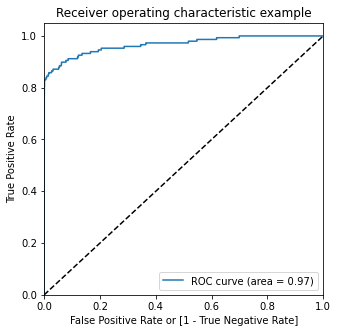

In [89]:
# Plot the ROC curve for Logistic Regresion

draw_roc(y_test, y_test_pred_proba_lr)

In [90]:
# Predicted probability FOR XgBoost
y_test_pred_proba_xgb = best_model_xgb.predict_proba(X_test)[:,1]
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_pred_proba_xgb)
auc


0.9709158041328744

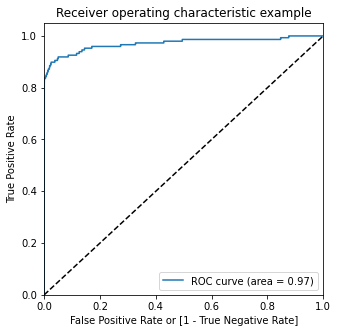

In [91]:
# Plot the ROC curve for XgBoost

draw_roc(y_test, y_test_pred_proba_xgb)

In [92]:
print('Train auc =', metrics.roc_auc_score(y_test, y_test_pred_proba_lr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_proba_lr)

threshold = thresholds[np.argmax(tpr-fpr)]
print("Threshold=",threshold)

Train auc = 0.9673152635606472
Threshold= 0.0034452699664573503


In [93]:
print('Train auc =', metrics.roc_auc_score(y_test, y_test_pred_proba_xgb))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_proba_xgb)

threshold = thresholds[np.argmax(tpr-fpr)]
print("Threshold=",threshold)

Train auc = 0.9709158041328744
Threshold= 0.00126994


We can see that among all the models we tried (Logistic, XGBoost, Decision Tree, and Random Forest), almost all of them have performed well.
More specifically Logistic regression ( roc auc :0.993083) and XGBoost ( roc auc :0.993420 ) performed best in terms of ROC-AUC score.
But if we were to choose one of them , we can go for the best as XGBoost which gives us best ROC score.

NOTE: You should see that best_model is of type RandomForestClassifier, and it should display the parameters of the random forest.

The reason it may show "Decision Tree" in the output is due to the way scikit-learn structures its code. The DecisionTreeClassifier is the base class for individual decision trees used within random forests, and it's possible that the naming convention is inherited from that.

In summary, seeing "Decision Tree" in the output of GridSearchCV when accessing the best_estimator_ attribute is not an issue. It's just a label used by scikit-learn, and the returned model is still a random forest with the best hyperparameters.

### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

#### Proceed with the model which shows the best result 
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [ ]:
clf = best_model_lr  #initialise the model with optimum hyperparameters
clf.fit(X_test, y_test)
print --> #print the evaluation score on the X_test by choosing the best evaluation metric

### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

In [ ]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## Model Building
- Build different models on the balanced dataset and see the result

In [ ]:
# Logistic Regression
from sklearn import linear_model #import the package

num_C = ______  #--> list of values
cv_num =   #--> list of values

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

### Random Oversampling

In [ ]:
from imblearn import over_sampling #- import the packages

#perform cross validation & then balance classes on X_train_cv & y_train_cv using Random Oversampling

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters


### Similarly explore other algorithms on balanced dataset by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

### Print the class distribution after applying SMOTE 

In [ ]:
import warnings
warnings.filterwarnings("ignore")


sm = over_sampling.SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [ ]:
#perform cross validation & then balance classes on X_train_cv & y_train_cv using SMOTE

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters


##### Build models on other algorithms to see the better performing on SMOTE

### Print the class distribution after applying ADASYN

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [ ]:
#perform cross validation & then balance classes on X_train_cv & y_train_cv using ADASYN

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters


##### Build models on other algorithms to see the better performing on ADASYN

### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [ ]:
# perform the best oversampling method on X_train & y_train

clf = ___  #initialise the model with optimum hyperparameters
clf.fit( ) # fit on the balanced dataset
print() --> #print the evaluation score on the X_test by choosing the best evaluation metric

### Print the important features of the best model to understand the dataset

In [ ]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

In [ ]:
#### Print the FPR,TPR & select the best threshold from the roc curve

In [ ]:
print('Train auc =', metrics.roc_auc_score(_________)
fpr, tpr, thresholds = metrics.roc_curve(_________)
threshold = thresholds[np.argmax(tpr-fpr)]
print(threshold)